In [ ]:
# finding single and double-positive cells

In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(ggpointdensity)
library(cowplot)
library(viridis)
library(ggbeeswarm)

In [3]:
# dataset 2
sc1 = readRDS('Yao_SSv4.rds')
sc1
mtd1 = sc1@meta.data
mtd1[1:2,]

An object of class Seurat 
35433 features across 73347 samples within 1 assay 
Active assay: RNA (35433 features, 0 variable features)
 1 layer present: data
 1 dimensional reduction calculated: umap

region_label cluster_order cluster_label   subclass_label
SM-DD45K_S170_E1-50 VISp         223           223_L6 IT CTX   L6 IT CTX     
SM-D9E5R_S80_E1-50  SSp          266           266_L5/6 NP CTX L5/6 NP CTX   
                    neighborhood_label class_label  
SM-DD45K_S170_E1-50 L4/5/6 IT Car3     Glutamatergic
SM-D9E5R_S80_E1-50  NP/CT/L6b          Glutamatergic
                    full_genotype_label                  
SM-DD45K_S170_E1-50 Oxtr-T2A-Cre/wt;Ai14(RCL-tdT)/wt     
SM-D9E5R_S80_E1-50  Slc17a7-IRES2-Cre/wt;Ai14(RCL-tdT)/wt
                    facs_population_plan_label injection_type_label
SM-DD45K_S170_E1-50 RFP-positive               ZZ_Missing          
SM-D9E5R_S80_E1-50  RFP-positive               ZZ_Missing          
                    injection_materials_id ⋯ tissue_type
SM-DD45K_S170_E1-50 1                      ⋯ tissue     
SM-D9E5R_S80_E1-50  1                      ⋯ tissue     
                    cell_type                                                                        
SM-DD45K_S170_E1-50 L6 intratelencephalic projecting glutamatergic neuron of the primary motor cortex
SM-D9E5R_S80_E1-50  L5/6 near-projecting glutamatergic neuron of the primary motor cortex            
                    assay        disease organism     sex   
SM-DD45K_S170_E1-50 Smart-seq v4 normal  Mus musculus male  
SM-D9E5R_S80_E1-50  Smart-seq v4 normal  Mus musculus female
                    tissue                       self_reported_ethnicity
SM-DD45K_S170_E1-50 primary visual cortex        na                     
SM-D9E5R_S80_E1-50  primary somatosensory cortex na                     
                    development_stage observation_joinid
SM-DD45K_S170_E1-50 7-week-old stage  C`cpuQ1S)%        
SM-D9E5R_S80_E1-50  7-week-old stage  HR|$jiI6kx

In [4]:
table(mtd1$development_stage)
keepids = which(mtd1$development_stage %in% c('7-week-old stage', '8-week-old stage', '9-week-old stage', '10-week-old stage', '11-week-old stage'))


 7-week-old stage  8-week-old stage  9-week-old stage 10-week-old stage 
            37276             30072              2886               483 
11-week-old stage 12-week-old stage 13-week-old stage 14-week-old stage 
              328                 1              1824               415 
15-week-old stage 
               62 

In [5]:
# cpm-normalize the raw counts
seu = CreateSeuratObject(counts = sc1@assays$RNA@data[,keepids], meta.data = sc1@meta.data[keepids,])
seu <- NormalizeData(seu, normalization.method = "RC", scale.factor = 1e6)
seu
exp1 = LayerData(seu, assay = 'RNA', layer = 'data') # cpm

Normalizing layer: counts



An object of class Seurat 
35433 features across 71045 samples within 1 assay 
Active assay: RNA (35433 features, 0 variable features)
 2 layers present: counts, data

In [6]:
genes = sc1@assays$RNA@meta.features$feature_name
ids = which(!is.na(genes))
exp2 = exp1[ids,]
rownames(exp2) = genes[ids]
exp2[1:2,1:2]

2 x 2 sparse Matrix of class "dgCMatrix"
              SM-DD45K_S170_E1-50 SM-D9E5R_S80_E1-50
0610005C13Rik                   .                  .
0610006L08Rik                   .                  .

In [7]:
sum(exp2['Neurog2',]>0)
sum(exp2['Ascl1',]>0)
sum(exp2['Neurog1',]>0)

[1] 1010

[1] 14867

[1] 116

In [8]:
# get new cell types for A1N2 and N1N2 cases
get_celltype_new <- function(exp0, g1, g2){
    gene1_exp = exp0[g1,]
    gene2_exp = exp0[g2,]
    
    vec1 = rank(gene1_exp)
    vec2 = rank(gene2_exp)
    
    vec1 <- vec1/max(vec1, na.rm = T)
    vec2 <- vec2/max(vec2, na.rm = T)

    id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
    id2 = which(vec1>0.7 & vec2<=0.7) # neurog2
    id3 = which(vec1<=0.7 & vec2>0.7) # ascl1

    ctypes = rep('none', dim(exp0)[2])
    ctypes[id1] = 'double_positive'
    ctypes[id2] = paste0(g1, '_positive')
    ctypes[id3] = paste0(g2, '_positive')

    return(ctypes)
}

In [9]:
# get cell type labels based on ranked exp bins
seu$celltype_A1N2 = get_celltype_new(exp2, 'Neurog2', 'Ascl1')
seu$celltype_N1N2 = get_celltype_new(exp2, 'Neurog2', 'Neurog1')

In [10]:
# save file
saveids = which(exp2['Neurog2',]>0 | exp2['Ascl1',]>0 | exp2['Neurog1',]>0)
length(saveids)

sce = CreateSeuratObject(counts = LayerData(seu, assay = 'RNA', layer = 'counts')[,saveids], 
                         data = exp2[,saveids], meta.data = seu@meta.data[saveids,])
sce

# save
saveRDS(sce, file = 'Yao_SSv4_A1N1N2.rds')

[1] 15742

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
70866 features across 15742 samples within 1 assay 
Active assay: RNA (70866 features, 0 variable features)
 2 layers present: counts, data

In [21]:
gene1_exp = exp2['Neurog2',]
gene2_exp = exp2['Neurog1',]

vec1 = rank(gene1_exp)
vec2 = rank(gene2_exp)

vec1 <- vec1/max(vec1, na.rm = T)
vec2 <- vec2/max(vec2, na.rm = T)

In [27]:
cor(vec1, vec2, method = 'spearman')

[1] 0.1315921

In [28]:
dat = data.frame(m1_exp = log2(1+gene1_exp), m2_exp = log2(1+gene2_exp),
                 m1_rank = vec1, m2_rank = vec2)
dat[1:2,]

m1_exp m2_exp   m1_rank   m2_rank  
P12_NxCLB1_AAACCCAAGGTTCAGG 0      7.979469 0.4777732 0.7609341
P12_NxCLB1_AAACCCACAACTCGAT 0      7.845099 0.4777732 0.7461846

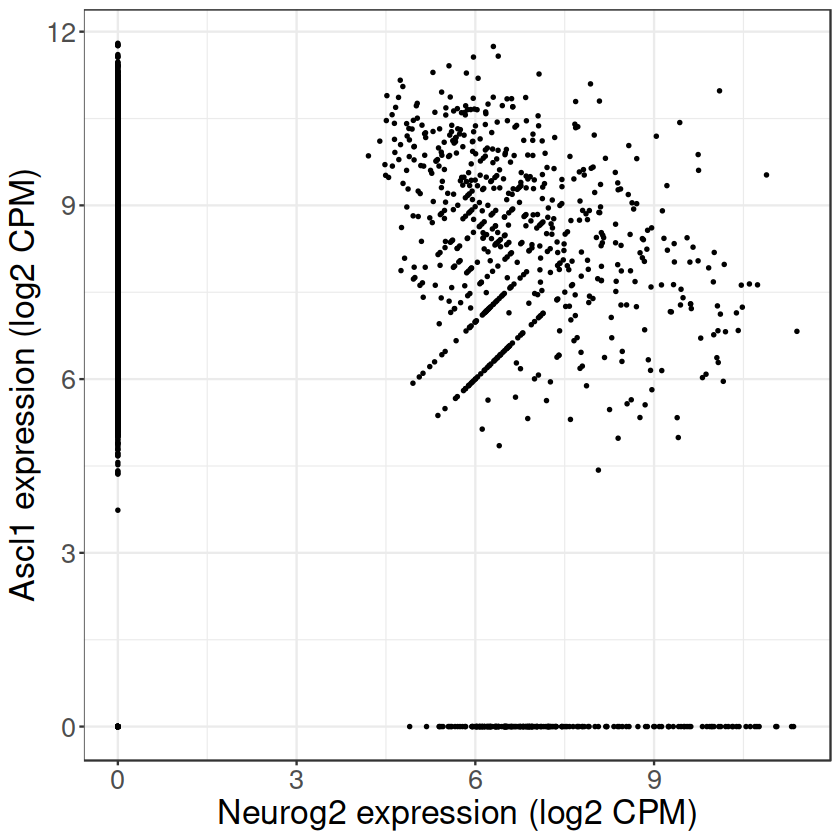

In [29]:
# png('aa-gene-exp-coexp.png', width = 5, height = 5, res = 300, units = 'in')
ggplot(dat, aes(x = m1_exp, y = m2_exp)) +
geom_point(size = 0.5) + theme_bw() + theme(text = element_text(size = 20)) +
xlab('Neurog2 expression (log2 CPM)') + ylab('Ascl1 expression (log2 CPM)')
# dev.off()

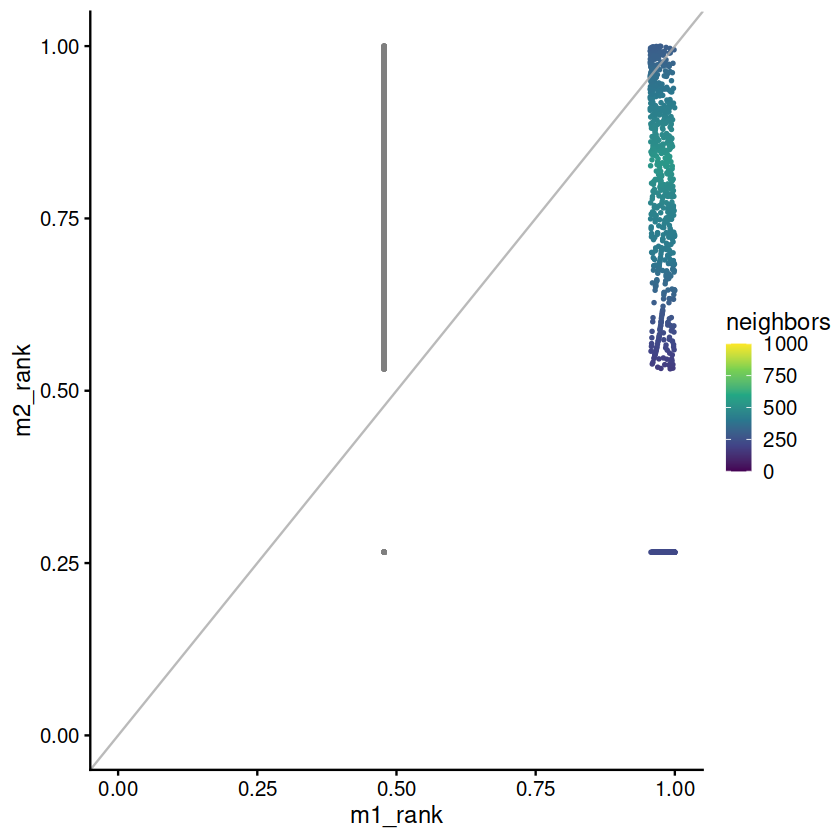

In [93]:
# png(paste0('aa-', g1, '-density-coexp.png'), width = 10, height = 5, res = 300, units = 'in')
# pdf(paste0('aa-hc-', g3, '-density-coexp.pdf'), width = 5, height = 5)

ggplot(dat, aes(x = m1_rank, y = m2_rank)) +
geom_pointdensity(size = 0.5) + scale_color_viridis_c(limits = c(0,1000)) + 
geom_abline(intercept = 0, slope = 1,col = 'darkgray', lwd = 0.5, alpha = 0.8)+
theme_cowplot() + labs(col = 'neighbors') + xlim(0,1) + ylim(0,1)

# dev.off()

In [22]:
id1 = which(vec1>0.7 & vec2>0.7) # dbl-positive
id2 = which(vec1>0.7 & vec2<0.7) # neurog2
id3 = which(vec1<0.7 & vec2>0.7) # ascl1

length(id1)
length(id2)
length(id3)

[1] 2

[1] 1008

[1] 114

In [14]:
# cluster 8,10,16,22 for dbl-pos; cluster 32 for neurog2+
table(as.character(mtd1$cell_type[id1]))


                                                                          astrocyte 
                                                                                  5 
                                                  central nervous system macrophage 
                                                                                  1 
                           corticothalamic-projecting glutamatergic cortical neuron 
                                                                                  4 
                                                                 hippocampal neuron 
                                                                                  7 
L2/3 intratelencephalic projecting glutamatergic neuron of the primary motor cortex 
                                                                                  6 
                          L2/3-6 intratelencephalic projecting glutamatergic neuron 
                                                                

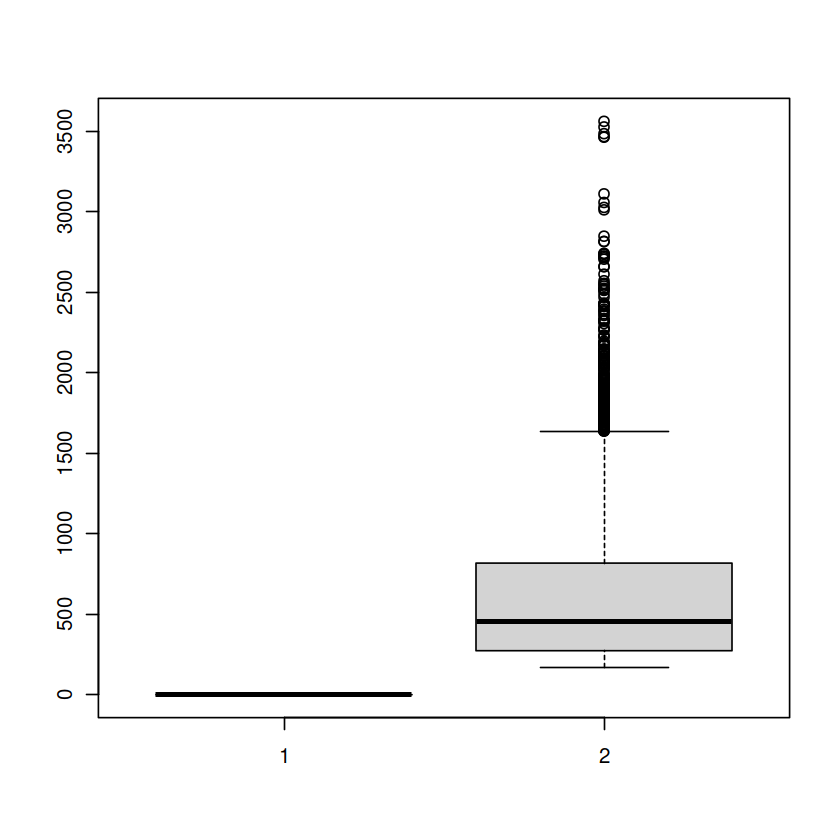

In [96]:
boxplot(exp1['Neurog2', id3], exp1['Ascl1', id3])

In [15]:
# Alex's target genes
alex = c('Bcl11a', 'Bcl11b', 'Nhlh1', 'Nhlh2', 'Sox2', 'Sox9', 'Gfap',
        'Pax6', 'Prom1', 'Foxj1', 'Rbfox3', 'Nes', 'Hopx', 'Dcx',
        'Bdnf', 'Pdgfra', 'S100b')
length(alex)

[1] 17

[1] "Nes"

[1] 1276

[1] 7

[1] 27

[1] 284

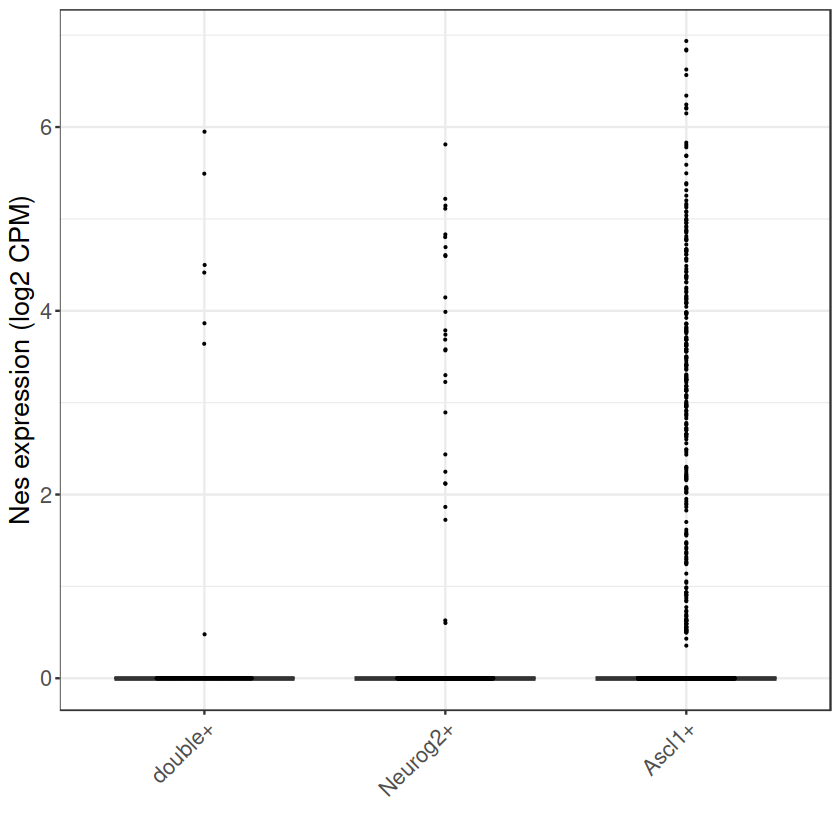

In [16]:
# other coexpressing genes
currgene = alex[12]
currgene
sum(exp2[currgene,]>0)

# no. of cells with >0 exp in each case
sum(exp2[currgene, id1]>0)
sum(exp2[currgene, id2]>0)
sum(exp2[currgene, id3]>0)

exp_vec = exp2[currgene,]
vec3 = rank(exp_vec)
vec3 <- vec3/max(vec3, na.rm = T)
plotdf = data.frame(gene = currgene, 
                    ctype = c(rep('double+', length(id1)), rep('Neurog2+', length(id2)), rep('Ascl1+', length(id3))),
                    exp = c(log2(1+exp_vec[id1]), log2(1+exp_vec[id2]), log2(1+exp_vec[id3])),
                    rank_exp = c(vec3[id1], vec3[id2], vec3[id3]))
plotdf$ctype = factor(plotdf$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))

# png(paste0('aa-', currgene, '-exp.png'), width = 3.5, height = 5, res = 300, units = 'in')
ggplot(plotdf, aes(x = ctype, y = exp, fill = ctype)) + 
geom_boxplot(outlier.shape = NA) + geom_quasirandom(size = 0.1, width = 0.2) + theme_bw() +
theme(text = element_text(size = 16), axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'none') +
xlab('') + ylab(paste0(currgene, ' expression (log2 CPM)')) + scale_fill_manual(values = c('#ff6b6b', '#48bf91', '#ffb403'))
# dev.off()

In [17]:
# which genes show the pattern we want? (apart from Alex's targets)
# expr in double-positive > single-positive cells
options(warn = -1)
allgenes = setdiff(rownames(exp2), c('Neurog2', 'Ascl1'))
length(allgenes)

# get row ranks
r1 = matrixStats::rowRanks(as.matrix(exp2[allgenes,c(id1,id2,id3)]))
r1 <- r1/dim(exp2)[2]

pb = txtProgressBar(min = 0, max = length(allgenes), initial = 0)
gset = c()

for(ii in 1:length(allgenes)){
    vec3 = r1[ii,]

    m1 = mean(vec3[1:length(id1)])
    m2 = mean(vec3[(length(id1)+1):(length(id1)+length(id2))])
    m3 = mean(vec3[(length(id1)+length(id2)+1):(length(id1)+length(id2)+length(id3))])
    
    if(m1>m2 & m1>m3){
        gset = c(gset, allgenes[ii])
    }
    setTxtProgressBar(pb, ii)
}

length(gset)

[1] 35431

[1] 10934

In [18]:
# wow, 10% follow our trend
pb = txtProgressBar(min = 0, max = length(gset), initial = 0)

dfnew = data.frame(gene = gset, dbl_exp = 0, gene1_exp = 0, 
                   gene2_exp = 0, retain = 0)

r2 = log2(1+exp2[gset,])

for(ii in 1:length(gset)){
    vec3 = r2[ii,]

    m1 = mean(vec3[id1])
    m2 = mean(vec3[id2])
    m3 = mean(vec3[id3])    

    dfnew$dbl_exp[ii] = m1
    dfnew$gene1_exp[ii] = m2
    dfnew$gene2_exp[ii] = m3
    
    if(m1>1.5*m2 & m1>1.5*m3 & m1>2){
        dfnew$retain[ii] = 1
    }
    setTxtProgressBar(pb, ii)
}
dfnew <- dfnew %>% arrange(-retain, -dbl_exp)

sum(dfnew$retain)
dfnew[1:2,]

[1] 85

gene   dbl_exp  gene1_exp gene2_exp retain
1 Pdzrn3 6.916213 4.483988  3.974586  1     
2 Nr4a1  5.840282 3.679768  3.867537  1

In [19]:
dfnew$gene[dfnew$retain==1]

[1] "Pdzrn3"        "Nr4a1"         "Coch"          "Cdh6"         
 [5] "Pamr1"         "Krt12"         "Grm2"          "Kcnh5"        
 [9] "Myo1b"         "Sema3a"        "Gfra2"         "Dkkl1"        
[13] "Dtl"           "Rorb"          "Trib2"         "Adcyap1"      
[17] "Ntng1"         "Ovol2"         "Rassf3"        "Medag"        
[21] "Ccdc3"         "Fras1"         "Sowahb"        "Plxnd1"       
[25] "Hkdc1"         "Gpr83"         "Col26a1"       "Pacsin3"      
[29] "Gm30340"       "Lsm11"         "Sntg2"         "Il1rapl2"     
[33] "Igfn1"         "Gdpd5"         "Wnt9a"         "Boc"          
[37] "Krt20"         "Ptgfrn"        "Zar1l"         "Whrn"         
[41] "Cdyl"          "Tnnt2"         "Lamc2"         "Zfp703"       
[45] "Tcap"          "Htr7"          "Myo1e"         "Mei1"         
[49] "Hsd11b1"       "Hspb3"         "S100b"         "C030013G03Rik"
[53] "A730060N03Rik" "C130074G19Rik" "1700047F07Rik" "Osbpl5"       
[57] "Sgpp2"         "Tnfrsf11a"     "Gm39822"       "Trib1"        
[61] "Aldh1l1"       "Opn3"          "Ocm"           "Rgs3"         
[65] "Slc23a3"       "Tmem268"       "Cacna1i"       "BC006965"     
[69] "Niban2"        "2600014E21Rik" "Dapk2"         "Sox9"         
[73] "Sh3pxd2b"      "Gm26868"       "Rhobtb1"       "Vsig2"        
[77] "Mmel1"         "Rbm20"         "Slc13a5"       "Tspan11"      
[81] "Tjp2"          "Aunip"         "Ccn4"          "Barx2"        
[85] "Egr2"

In [20]:
# df for saving
write.table(dfnew, file = 'yao_SSv4_neurog2_ascl1_geneset.csv', sep = ',',
           row.names = F, col.names = T, quote = F)

In [42]:
# show avg exp and pct expressed
geneset = rev(c('Nes', 'Thrsp', 'Gpc5', 'Efhd2', 'Gpc4', 'Gli2', 'Adarb1'))
plotdf2 = c()

for(ii in 1:length(geneset)){
    currgene = geneset[ii]
    exp_vec = exp1[currgene,]
    
    temp = data.frame(gene = currgene, 
                        ctype = c('double+', 'Neurog2+', 'Ascl1+'),
                        log2_exp = c(mean(log2(1+exp_vec[id1])), mean(log2(1+exp_vec[id2])), mean(log2(1+exp_vec[id3]))),
                        pct_exp = c(sum(exp1[currgene, id1]>0)/length(id1), 
                                sum(exp1[currgene, id2]>0)/length(id2), sum(exp1[currgene, id3]>0)/length(id3)))
    plotdf2 = rbind(plotdf2, temp) 
}

plotdf2$ctype = factor(plotdf2$ctype, levels = c('double+', 'Neurog2+', 'Ascl1+'))
plotdf2$gene = factor(plotdf2$gene, levels = geneset)
plotdf2[1:3,]

gene   ctype    log2_exp  pct_exp  
1 Adarb1 double+  0.6800809 0.1255230
2 Adarb1 Neurog2+ 0.6340548 0.1023018
3 Adarb1 Ascl1+   0.7318099 0.1314126

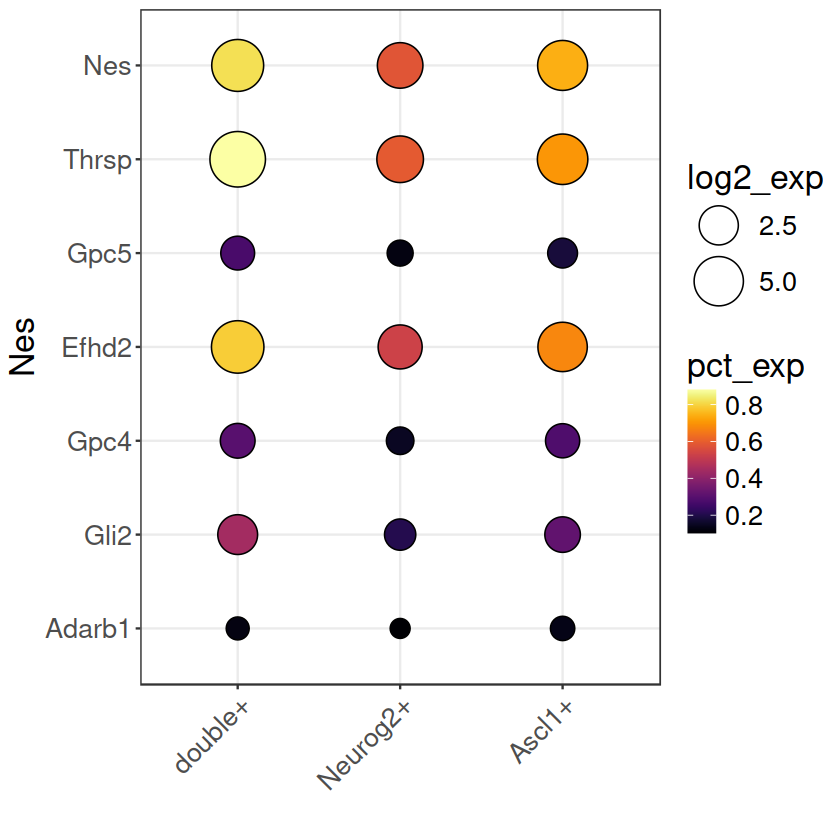

In [45]:
# png('aa-geneset-exp-pct.png', width = 5, height = 6, res = 300, units = 'in')
ggplot(plotdf2, aes(x = ctype, y = gene, label = round(pct_exp*100)/100)) +  
geom_point(shape = 21, color = 'black', aes(fill = pct_exp, size = log2_exp)) + theme_bw() + 
# geom_text(size = 6, hjust = -0.25, vjust = -2) + 
theme(text = element_text(size = 20), axis.text.x = element_text(angle = 45, hjust = 1)) +
xlab('') + ylab(currgene) + scale_fill_viridis(option = 'B') +
scale_size_continuous(breaks = c(0, 2.5, 5, 7.5, 10, 12.5, 15), range = c(5, 15)) 
# dev.off()